In [1]:
import os
import io
import time
import pickle
import pandas as pd
import numpy as np

import cv2
from skimage import transform
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


image_dir = r"C:\Users\Leo's PC\Desktop\images"
csv_dir = r"C:\Users\Leo's PC\Desktop\AVA.txt"
checkpoint_save_dir = r"C:\Users\Leo's PC\PycharmProjects\PD\Model Checkpoints"

### Dangerous

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# AVA Dataset Class

In [3]:
class AVADataset(Dataset):
    """AVA dataset."""

    def __init__(self, csv_file, file_dir, start, end, class_size=None, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            file_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            start&end: specify the range in the raw data to construct the dataset from. For spliting calidation and test sets.
            class_size = make the amount of images in each rating group equal to class_size.
        """
        self.csv = pd.read_csv(csv_file, sep=' ')
        self.file_dir = file_dir
        self.transform = transform
        self.diction = {}
        self.start = start
        self.end = end
        self.class_size = class_size

        for _, _, files in os.walk(self.file_dir): #get a list of file names in the dataset folder
            self.img_name_array = files

        self.img_name_array = self.img_name_array[start:end] #limit the range of file names to start:end

        index = 0
        self.rat_distribution = np.zeros(9, dtype=np.int16)
        print("index =", index, "AVA Dataset initialization begin...")
        print("Rating distribution initialized: ", self.rat_distribution)
        for csv_idx, row in self.csv.iterrows(): #traverse the enitre csv file
            image_name = row[1]
            if (str(image_name) + '.jpg') in self.img_name_array: 
                #only add [image_name, avg_rat] to diction when it's in the img_name_array
               
                rating_array = np.array(row[2:12])
                avg_rat = np.argmax(rating_array) + 1
                if class_size: #when it's needed to limit class amount
                    if self.rat_distribution[avg_rat - 2] < class_size: #only enter if under limit
                        self.diction[index] = [image_name, avg_rat] #append
                        self.rat_distribution[avg_rat - 2] += 1 #update rat_distribution
                        index += 1 #update index
                else: #when class amount is not specified. Just append.
                    self.diction[index] = [image_name, avg_rat] #append
                    index += 1 #update index
                if csv_idx % 10000 == 0:
                    print('csv_idx:', csv_idx, 'index:', index, 'img_name', image_name, 'avg_rat', avg_rat,"\n",
                          " - Current rating distribution is: ", self.rat_distribution)
            
        print("Stage 1 loading complete. Current rating distribution is: ", self.rat_distribution)

        plt.bar(np.arange(9), self.rat_distribution, 0.35) #(indeces, data, width)
        plt.ylabel('Number of Pictures')
        plt.title('Current Rating Distribution')
        plt.xticks(np.arange(9), ('1', '2', '3', '4', '5', '6', '7', '8', '9'))
        plt.show()
        
        #now that all classes are <= class_limit, we need to make all of them = class limit
        if class_size: #only proceed when it's needed to limit class amount
            self.distribution_multiplier = np.ceil(np.divide(np.full(9, self.class_size), self.rat_distribution))
            #np.ceil rounds up to provide enough images in each class. np.fill creates an array with 9 elements = class_size
            print("Stage 2 begin. Target class size is:", class_size, "Distribution multiplier is:", self.distribution_multiplier)
            self.additional_diction = {}
            for item in self.diction.items(): #traverse the self.diction
                img_name = item[1][0]
                avg_rat = item[1][1]
                if self.rat_distribution[avg_rat - 2] < class_size: #only enter if < class_limit
                    for i in range(int(self.distribution_multiplier[avg_rat - 2])):
                        self.additional_diction[len(self.diction) + len(self.additional_diction)] = [image_name, avg_rat]
                        #append the same image at the end of additional_diction (distribution_multiplier) times
                    self.rat_distribution[avg_rat - 2] += self.distribution_multiplier[avg_rat - 2] #update rat_distribution
            self.diction.update(self.additional_diction) #combine diction and additional_diction
                    
        print("AVA Dataset initialization complete. Rating distribution is: ", self.rat_distribution, "\n",
        "contains", len(self.diction), "items.")
        
        plt.bar(np.arange(9), self.rat_distribution, 0.35) #(indeces, data, width)
        plt.ylabel('Number of Pictures')
        plt.title('Current Rating Distribution')
        plt.xticks(np.arange(9), ('1', '2', '3', '4', '5', '6', '7', '8', '9'))
        plt.show()
                        
                        
    def __len__(self):
        return len(self.diction)

    
    def __getitem__(self, idx):
        img_name = self.diction[idx][0]
        rat_avg = self.diction[idx][1]
        directory = self.file_dir + "\\" + str(img_name) + '.jpg'
        image = cv2.imread(directory, cv2.IMREAD_COLOR)
        sample = {'image': np.array(image, dtype=float), 'rating': np.array(rat_avg, dtype=float)}
        if self.transform:
            sample = self.transform(sample)
        return sample

# Helper Functions for Dataset Transformation

In [4]:
class Rescale(object):
    
    """
    Rescale the image in a sample to a given size.

    Args:
     output_size (tuple or int): Desired output size. If tuple, output is
         matched to output_size. If int, smaller of image edges is matched
         to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, rating = sample['image'], sample['rating']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return {'image': img, 'rating': rating}


class ToTensor(object):
    
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, rating = sample['image'], sample['rating']
        rating = np.array(rating)
        image = image.transpose((2, 0, 1)) #swap color axis because: numpy image: H x W x C & torch image: C X H X W
        return {'image': torch.from_numpy(image),
                 'rating': torch.from_numpy(rating)}

# Create Dataset Instances and DataLoaders

index = 0 AVA Dataset initialization begin...
Rating distribution initialized:  [0 0 0 0 0 0 0 0 0]
csv_idx: 20000 index: 14275 img_name 451851 avg_rat 6 
  - Current rating distribution is:  [   4   73 1399 8471 3897  355   42    1   33]
csv_idx: 30000 index: 18608 img_name 348334 avg_rat 5 
  - Current rating distribution is:  [    5    97  2129 10000  5731   542    51     2    51]
csv_idx: 40000 index: 21339 img_name 584770 avg_rat 5 
  - Current rating distribution is:  [   10   129  3064 10000  7295   688    75     2    76]
csv_idx: 50000 index: 24287 img_name 324746 avg_rat 4 
  - Current rating distribution is:  [   11   167  4067 10000  8994   841    98     4   105]
csv_idx: 60000 index: 26423 img_name 527494 avg_rat 5 
  - Current rating distribution is:  [   14   193  4923 10000 10000  1036   121     5   131]
csv_idx: 70000 index: 27383 img_name 682519 avg_rat 6 
  - Current rating distribution is:  [   15   215  5582 10000 10000  1267   147     5   152]
csv_idx: 80000 index:

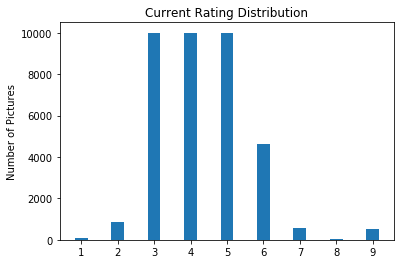

Stage 2 begin. Target class size is: 10000 Distribution multiplier is: [113.  12.   1.   1.   1.   3.  19. 477.  21.]
AVA Dataset initialization complete. Rating distribution is:  [10033 10009 10000 10000 10000 10002 10011 10038 10012] 
 contains 90105 items.


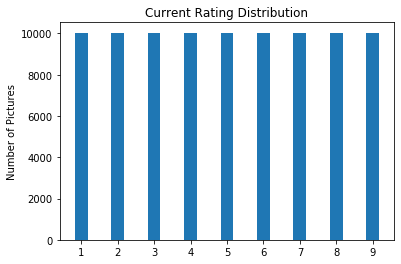

index = 0 AVA Dataset initialization begin...
Rating distribution initialized:  [0 0 0 0 0 0 0 0 0]
csv_idx: 10000 index: 2295 img_name 758229 avg_rat 5 
  - Current rating distribution is:  [   0   10  182 1314  721   61    6    0    1]
csv_idx: 90000 index: 7608 img_name 776483 avg_rat 5 
  - Current rating distribution is:  [   4   44 1057 3000 3000  446   32    1   24]
csv_idx: 120000 index: 8351 img_name 814905 avg_rat 6 
  - Current rating distribution is:  [   4   58 1459 3000 3000  757   43    1   29]
csv_idx: 220000 index: 10387 img_name 807308 avg_rat 5 
  - Current rating distribution is:  [   9  130 2828 3000 3000 1233   95    7   85]
csv_idx: 230000 index: 10633 img_name 814300 avg_rat 5 
  - Current rating distribution is:  [  13  143 3000 3000 3000 1278  100    7   92]
Stage 1 loading complete. Current rating distribution is:  [  13  160 3000 3000 3000 1398  107    7   96]


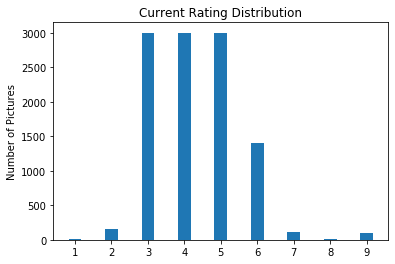

Stage 2 begin. Target class size is: 3000 Distribution multiplier is: [231.  19.   1.   1.   1.   3.  29. 429.  32.]
AVA Dataset initialization complete. Rating distribution is:  [3016 3010 3000 3000 3000 3000 3007 3010 3008] 
 contains 27051 items.


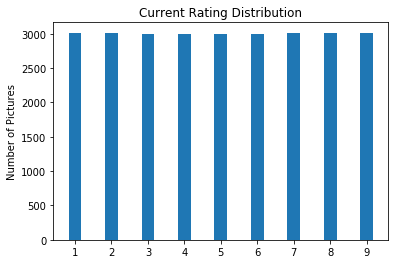

In [5]:
AVA_Train = AVADataset(csv_file=csv_dir, file_dir=image_dir, start=0, end=179999, class_size=10000, transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))
AVA_Validation = AVADataset(csv_file=csv_dir, file_dir=image_dir, start=180000, end=229999, class_size=3000, transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))
# AVA_Test = AVADataset(csv_file=csv_dir, file_dir=image_dir, start=230000, end=249999, transform=transforms.Compose([Rescale((224, 224)), ToTensor()]))

train_loader = DataLoader(dataset=AVA_Train, batch_size=2,shuffle=True)
val_loader = DataLoader(dataset=AVA_Validation, batch_size=2, shuffle=True)

# Load Pretrained Models for Transfer Learning

In [6]:
VGG = torchvision.models.vgg19_bn(pretrained=True)
VGG.classifier._modules['0'] = nn.Linear(25088, 4096)
VGG.classifier._modules['3'] = nn.Linear(4096, 4096)
VGG.classifier._modules['6'] = nn.Linear(4096, 1)

# Model Class

In [7]:
class LeoNet(nn.Module):
    def __init__(self):
        super(LeoNet, self).__init__()
        self.VGG = VGG  # input shape is 224*224*3

    def forward(self, x):
        x = VGG(x)
        return x

    def name(self):
        return "LeoNet"

# Model Initialization & Hyperparameters

In [8]:
model = LeoNet()
print(model)

LeoNet(
  (VGG): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [9]:
optimizer = optim.Adam(params=model.parameters(), lr=0.0001, betas=(0.9, 0.999))
criterion = nn.MSELoss()

### Initialization for single-GPU/CPU training ONLY

In [10]:
model = model.cuda()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
model.to(device)

True


LeoNet(
  (VGG): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

# Training Code

In [12]:
global epoch #declear epoch global, to be used later by torch.save() 

for epoch in range(10):

    ave_loss = 0
    global loss #declear loss global, to be used later by torch.save() 
    for batch_idx, diction in enumerate(train_loader):
        model.train() #set model to traning mode
        optimizer.zero_grad()
        x, target = diction['image'], diction['rating'] #extract training data for this batch
        # target = target.resize_(20)
        x, target = x.float(), target.float() #set datatype
        x, target = x.to(device), target.to(device) #transfer to GPU
        x, target = Variable(x), Variable(target) #set to pytorch datatype: variable
        out = model(x) #forward pass
        loss = criterion(out, target.resize_([2, 1])) #calculate loss
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1 
        loss.backward() #back propagation with calculated loss
        optimizer.step() #calculate gradient and step
        if (batch_idx + 1) % 1000 == 0 or (batch_idx + 1) == len(train_loader):
            print('==>>> epoch: {}, batch index: {}, train loss: {:.6f}'.format(epoch, batch_idx + 1, loss))

    correct_cnt, ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, diction in enumerate(val_loader):
        model.eval() #set model to evaluation mode
        x, target = diction['image'], diction['rating']
        # target = target.resize_(20)
        x, target = x.float(), target.float()
        x, target = x.to(device), target.to(device)
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target.resize_([2, 1]))
        pred_label = out.data.int().float().resize_(2) 
        # make out.data int to remove decimals, revert to float and resize for the datatype to match when using .sum()
        total_cnt += x.data.size()[0]
        correct_cnt += (pred_label == target.data).sum()
        ave_loss = ave_loss * 0.9 + loss.item() * 0.1 #smooth average
        if (batch_idx + 1) % 1000 == 0 or (batch_idx + 1) == len(val_loader):
            print(
            '==>>> epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx + 1, ave_loss, correct_cnt.item() * 1.0 / total_cnt))
            print(pred_label.data, target.data)

==>>> epoch: 0, batch index: 1000, train loss: 4.669499
==>>> epoch: 0, batch index: 2000, train loss: 7.333076
==>>> epoch: 0, batch index: 3000, train loss: 10.752376
==>>> epoch: 0, batch index: 4000, train loss: 0.788775
==>>> epoch: 0, batch index: 5000, train loss: 1.881124
==>>> epoch: 0, batch index: 6000, train loss: 1.543768
==>>> epoch: 0, batch index: 7000, train loss: 16.722252
==>>> epoch: 0, batch index: 8000, train loss: 1.545300
==>>> epoch: 0, batch index: 9000, train loss: 6.969606
==>>> epoch: 0, batch index: 10000, train loss: 9.179030
==>>> epoch: 0, batch index: 11000, train loss: 7.843976
==>>> epoch: 0, batch index: 12000, train loss: 1.103102
==>>> epoch: 0, batch index: 13000, train loss: 13.015014
==>>> epoch: 0, batch index: 14000, train loss: 6.658174
==>>> epoch: 0, batch index: 15000, train loss: 3.136650
==>>> epoch: 0, batch index: 16000, train loss: 2.109450
==>>> epoch: 0, batch index: 17000, train loss: 8.741089
==>>> epoch: 0, batch index: 18000, t

C:\ProgramData\Anaconda3\envs\pd\lib\site-packages\torch\nn\modules\loss.py:432: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


==>>> epoch: 0, batch index: 45053, train loss: 4.725105
==>>> epoch: 0, batch index: 1000, test loss: 0.737510, acc: 0.818
tensor([5., 5.], device='cuda:0') tensor([[6.],
        [5.]], device='cuda:0')
==>>> epoch: 0, batch index: 2000, test loss: 0.657841, acc: 0.845
tensor([4., 5.], device='cuda:0') tensor([[6.],
        [5.]], device='cuda:0')
==>>> epoch: 0, batch index: 3000, test loss: 0.806808, acc: 0.802
tensor([4., 5.], device='cuda:0') tensor([[6.],
        [6.]], device='cuda:0')
==>>> epoch: 0, batch index: 4000, test loss: 2.103366, acc: 0.724
tensor([4., 5.], device='cuda:0') tensor([[4.],
        [4.]], device='cuda:0')
==>>> epoch: 0, batch index: 5000, test loss: 4.630933, acc: 0.703
tensor([6., 7.], device='cuda:0') tensor([[4.],
        [1.]], device='cuda:0')
==>>> epoch: 0, batch index: 6000, test loss: 4.314698, acc: 0.618
tensor([4., 4.], device='cuda:0') tensor([[7.],
        [7.]], device='cuda:0')
==>>> epoch: 0, batch index: 7000, test loss: 4.145288, acc: 

==>>> epoch: 2, batch index: 26000, train loss: 8.859892
==>>> epoch: 2, batch index: 27000, train loss: 4.799541
==>>> epoch: 2, batch index: 28000, train loss: 7.097206
==>>> epoch: 2, batch index: 29000, train loss: 10.186281
==>>> epoch: 2, batch index: 30000, train loss: 8.049887
==>>> epoch: 2, batch index: 31000, train loss: 1.263427
==>>> epoch: 2, batch index: 32000, train loss: 10.985079
==>>> epoch: 2, batch index: 33000, train loss: 4.648409
==>>> epoch: 2, batch index: 34000, train loss: 6.231001
==>>> epoch: 2, batch index: 35000, train loss: 7.158130
==>>> epoch: 2, batch index: 36000, train loss: 7.733141
==>>> epoch: 2, batch index: 37000, train loss: 6.889097
==>>> epoch: 2, batch index: 38000, train loss: 0.122411
==>>> epoch: 2, batch index: 39000, train loss: 3.279079
==>>> epoch: 2, batch index: 40000, train loss: 5.338599
==>>> epoch: 2, batch index: 41000, train loss: 0.484247
==>>> epoch: 2, batch index: 42000, train loss: 6.413973
==>>> epoch: 2, batch index: 

==>>> epoch: 4, batch index: 6000, train loss: 6.271185
==>>> epoch: 4, batch index: 7000, train loss: 7.766613
==>>> epoch: 4, batch index: 8000, train loss: 10.515640
==>>> epoch: 4, batch index: 9000, train loss: 2.349943
==>>> epoch: 4, batch index: 10000, train loss: 3.919986
==>>> epoch: 4, batch index: 11000, train loss: 3.663414
==>>> epoch: 4, batch index: 12000, train loss: 6.880255
==>>> epoch: 4, batch index: 13000, train loss: 10.638359
==>>> epoch: 4, batch index: 14000, train loss: 11.701506
==>>> epoch: 4, batch index: 15000, train loss: 7.237462
==>>> epoch: 4, batch index: 16000, train loss: 3.385210
==>>> epoch: 4, batch index: 17000, train loss: 1.361278
==>>> epoch: 4, batch index: 18000, train loss: 7.757658
==>>> epoch: 4, batch index: 19000, train loss: 11.633323
==>>> epoch: 4, batch index: 20000, train loss: 12.915934
==>>> epoch: 4, batch index: 21000, train loss: 5.029591
==>>> epoch: 4, batch index: 22000, train loss: 10.509087
==>>> epoch: 4, batch index: 

==>>> epoch: 5, batch index: 9000, test loss: 9.751775, acc: 0.423
tensor([5., 5.], device='cuda:0') tensor([[2.],
        [2.]], device='cuda:0')
==>>> epoch: 5, batch index: 10000, test loss: 14.959014, acc: 0.380
tensor([5., 5.], device='cuda:0') tensor([[9.],
        [9.]], device='cuda:0')
==>>> epoch: 5, batch index: 11000, test loss: 16.170961, acc: 0.346
tensor([5., 5.], device='cuda:0') tensor([[1.],
        [1.]], device='cuda:0')
==>>> epoch: 5, batch index: 12000, test loss: 8.830358, acc: 0.317
tensor([5., 5.], device='cuda:0') tensor([[8.],
        [8.]], device='cuda:0')
==>>> epoch: 5, batch index: 13000, test loss: 9.772741, acc: 0.293
tensor([5., 5.], device='cuda:0') tensor([[2.],
        [2.]], device='cuda:0')
==>>> epoch: 5, batch index: 13526, test loss: 5.618127, acc: 0.281
tensor([5., 3.], device='cuda:0') tensor([[3.],
        [0.]], device='cuda:0')
==>>> epoch: 6, batch index: 1000, train loss: 2.125280
==>>> epoch: 6, batch index: 2000, train loss: 1.481746

==>>> epoch: 7, batch index: 1000, test loss: 0.824036, acc: 0.841
tensor([6., 5.], device='cuda:0') tensor([[6.],
        [5.]], device='cuda:0')
==>>> epoch: 7, batch index: 2000, test loss: 1.018748, acc: 0.874
tensor([4., 5.], device='cuda:0') tensor([[6.],
        [5.]], device='cuda:0')
==>>> epoch: 7, batch index: 3000, test loss: 0.812503, acc: 0.844
tensor([5., 6.], device='cuda:0') tensor([[6.],
        [6.]], device='cuda:0')
==>>> epoch: 7, batch index: 4000, test loss: 1.733782, acc: 0.767
tensor([4., 5.], device='cuda:0') tensor([[4.],
        [4.]], device='cuda:0')
==>>> epoch: 7, batch index: 5000, test loss: 2.901702, acc: 0.749
tensor([6., 4.], device='cuda:0') tensor([[4.],
        [1.]], device='cuda:0')
==>>> epoch: 7, batch index: 6000, test loss: 3.082812, acc: 0.662
tensor([5., 5.], device='cuda:0') tensor([[7.],
        [7.]], device='cuda:0')
==>>> epoch: 7, batch index: 7000, test loss: 4.462949, acc: 0.568
tensor([5., 5.], device='cuda:0') tensor([[3.],
   

==>>> epoch: 9, batch index: 27000, train loss: 4.446368
==>>> epoch: 9, batch index: 28000, train loss: 7.265223
==>>> epoch: 9, batch index: 29000, train loss: 4.656508
==>>> epoch: 9, batch index: 30000, train loss: 5.543957
==>>> epoch: 9, batch index: 31000, train loss: 10.844027
==>>> epoch: 9, batch index: 32000, train loss: 0.273107
==>>> epoch: 9, batch index: 33000, train loss: 6.013879
==>>> epoch: 9, batch index: 34000, train loss: 4.697891
==>>> epoch: 9, batch index: 35000, train loss: 8.194887
==>>> epoch: 9, batch index: 36000, train loss: 1.447650
==>>> epoch: 9, batch index: 37000, train loss: 13.786537
==>>> epoch: 9, batch index: 38000, train loss: 6.119644
==>>> epoch: 9, batch index: 39000, train loss: 9.230254
==>>> epoch: 9, batch index: 40000, train loss: 10.083046
==>>> epoch: 9, batch index: 41000, train loss: 3.678915
==>>> epoch: 9, batch index: 42000, train loss: 1.713620
==>>> epoch: 9, batch index: 43000, train loss: 2.536857
==>>> epoch: 9, batch index:

In [ ]:
model_name = "LN_VGG16"
checkpoint_save_dir = r"C:\Users\Leo's PC\PycharmProjects\PD\Model Checkpoints"
checkpoint_file = open(checkpoint_save_dir + "\\" + model_name + "_" + "E" + str(epoch) + "_" + time.strftime("%m.%d.%Y_%H.%M.%S") 
                       + ".tar", 'wb')

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, checkpoint_file)

checkpoint_file.close()

In [11]:
checkpoint = torch.load(open(checkpoint_save_dir + "\LN_VGG16_E0_06.27.2020_16.25.57.tar", 'rb'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [ ]:
sample = AVA[25000]
print(i, sample['image'].size(), sample['rating'])
img = sample['image'][1]
img = np.array(img)
plt.imshow(img)